In [12]:
###########################################
# NACA aerofoil high order mesh generator #
# Zhenyang Yuan                           #
# 31/05/2021                              #
###########################################

In [13]:
import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import scipy.signal
#from matplotlib.mlab import griddata
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (14,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
#%matplotlib notebook
%matplotlib inline


from sys import argv

import pandas as pd

import triangle as tr

In [14]:
### build the NACA aerofoil
### refernce web page: http://airfoiltools.com/airfoil/naca4digit?MNaca4DigitForm%5Bcamber%5D=0&MNaca4DigitForm%5Bposition%5D=0&MNaca4DigitForm%5Bthick%5D=12&MNaca4DigitForm%5BnumPoints%5D=200&MNaca4DigitForm%5BcosSpace%5D=0&MNaca4DigitForm%5BcosSpace%5D=1&MNaca4DigitForm%5BcloseTe%5D=0&MNaca4DigitForm%5BcloseTe%5D=1&yt0=Plot
### this program is only valid for NACA 00XX aerofoils, note yc = xc = 0 here
beta = np.linspace(0,pi,100)

xc = 0.5*(1-np.cos(beta))
yc = np.zeros(len(xc))  #chamber line



## The constants a0 to a4 are for a 20% thick airfoil. The expression T/0.2 adjusts the constants to the required thickness.
a0 = 0.2969
a1 = -0.126
a2 = -0.3516
a3 = 0.2843
a4 = -0.1015

T = 0.12  ## aerofoil NACA 0012



yt = T/0.2*(a0*xc**0.5+a1*xc+a2*xc**2+a3*xc**3+a4*xc**4)   #thickness respect to x

theta = np.arctan2(yc,xc)

xu = xc - yt*np.sin(theta)
yu = yc + yt*np.cos(theta)

xl = xc + yt*np.sin(theta)
yl = yc - yt*np.cos(theta)


In [15]:
### round up the trailing edge
def modify_tail(x_t,y_t,N):
    x_c = 0.98 - 0.004*0.98
    y_c = 0

    xa = np.asarray([])
    ya = np.asarray([])
    for i in range(len(x_t)):
        xa = np.concatenate((xa,x_t[i]),axis=None)
        ya = np.concatenate((ya,y_t[i]),axis=None)
        if x_t[i] > 0.98:
            break
    
    
    k = (ya[-2] - ya[-3])/(xa[-2] - xa[-3])
    #print(k)
    kk = -1/k
    

    ## calculate the point when circle is tangent to aerofoil
    ax = -((y_c - kk*x_c) - (ya[-2] - k*xa[-2])) / (kk - k)    
    ay = kk*ax + y_c - kk*x_c
    
    xa[-2] = ax
    ya[-2] = ay
    
    #calculate the edge points of circle arc
    print(np.sqrt((ay-y_c)**2+(ax-x_c)**2)+x_c)
    rr = np.sqrt((ay-y_c)**2+(ax-x_c)**2)
    xa[-1] = rr+x_c
    ya[-1] = 0
    
    beta = np.linspace(pi-np.arctan2(ay-y_c,ax-x_c),pi,N)
    #print(beta)
    xx = x_c - np.cos(beta)*rr
    xa = np.concatenate((xa[0:-2],xx),axis=None)
    ya = np.concatenate((ya[0:-2],rr*np.sin(beta)+y_c),axis=None)
    
    
    #print(xx)
    
    return xa,ya,x_c,y_c

In [16]:
xu,yu,x_c,y_c = modify_tail(xu,yu,10)
xl,yl,x_c,y_c = modify_tail(xl,yl,10)

0.9806050635537246
0.9806050635537246


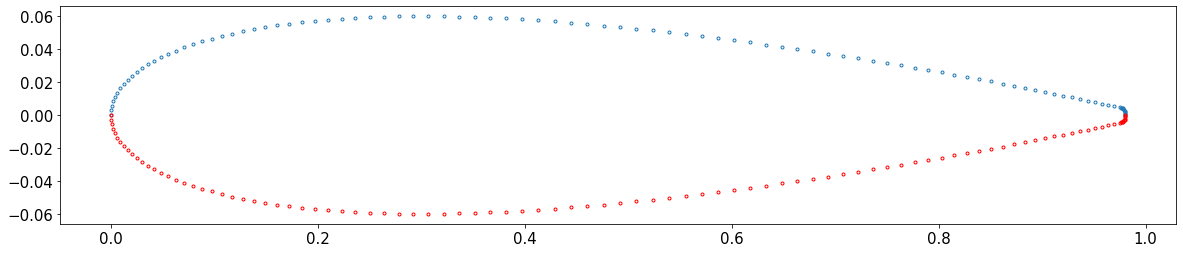

In [17]:
plt.figure(figsize=(20,4))
plt.plot(xu,yu,'.')
plt.plot(xl,yl,'r.')


(0.95, 1.02)

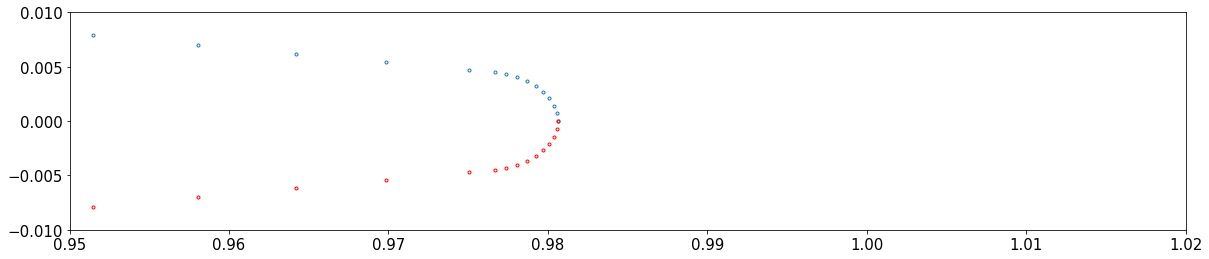

In [18]:
plt.figure(figsize=(20,4))
plt.plot(xu,yu,'.')
plt.plot(xl,yl,'r.')
plt.ylim([-0.01,0.01])
plt.xlim([0.95,1.02])

In [19]:
## rotation, the default centre point is (0,0,0)
def rotate(x,y):
    deg = -pi/60    # degree in rad
    x = x*np.cos(deg) - y*np.sin(deg)
    y = x*np.sin(deg) + y*np.cos(deg)
    return x,y

xu,yu = rotate(xu,yu)
xl,yl = rotate(xl,yl)
x_c,y_c = rotate(x_c,y_c)

print(x_c,y_c)

0.9747423162832444 -0.05101407121314559


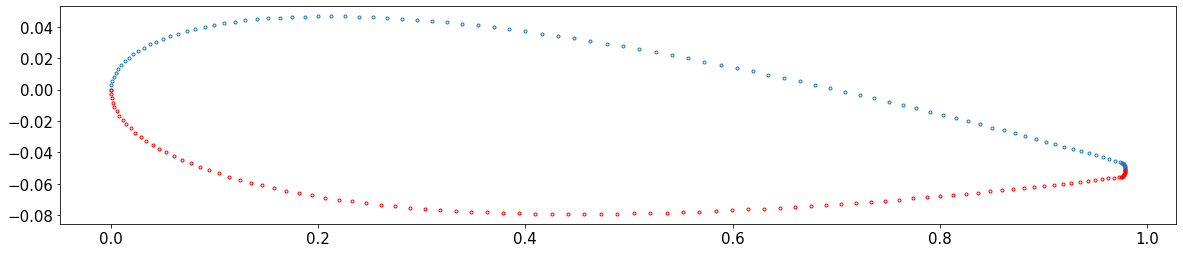

In [20]:
plt.figure(figsize=(20,4))
plt.plot(xu,yu,'.')
plt.plot(xl,yl,'r.')
#plt.xlim([0.96,0.985])
#plt.ylim([-0.06,-0.04])


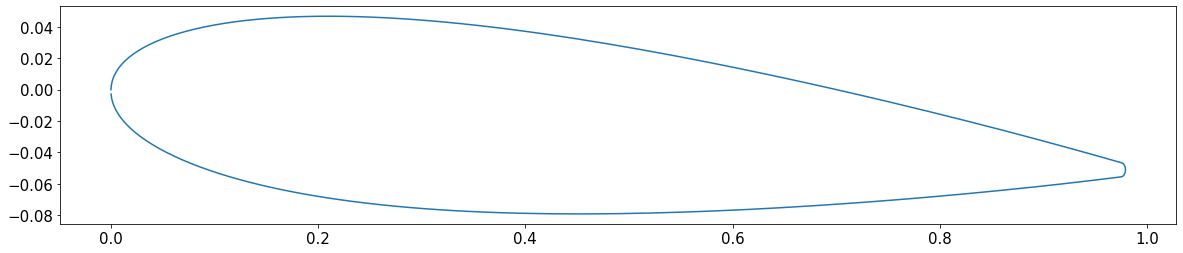

In [21]:
xl=xl[::-1]
yl=yl[::-1]

x = np.concatenate((xu,xl[1:-1]),axis=None)
y = np.concatenate((yu,yl[1:-1]),axis=None)

plt.figure(figsize=(20,4))
plt.plot(x,y,'-')

In [22]:
#write to the file
##write to gmsh format
f = open("aerofoil_spline.txt", "a")

f.write('//NACA 0012 with modification at trailing edge, rotation deg = 3\n')

#points aerofoil
for i in range(len(x)):
    f.write('Point('+str(i+1)+')'+' = '+'{'+str(x[i])+', '+str(y[i])+', 0, 1.0};'+'\n')
#f.write('Point('+str(i+2)+')'+' = '+'{'+str(x_c)+', '+str(y_c)+', 0, 1.0};'+'\n')  #central point
#f.write('Point('+str(i+3)+')'+' = '+'{'+str(0.9806044385883823)+', '+str(0.0)+', 0, 1.0};'+'\n')  #central point


for i in range(len(x)):
    f.write(str(i+1)+', ')


f.close()




In [ ]:
### try to make some beautiful meshes

In [40]:
def pre_mesh(xl,yl,xu,yu):
    xl=xl[::-1]
    yl=yl[::-1]

    x = np.concatenate((xu,xl[1:-1]),axis=None)
    y = np.concatenate((yu,yl[1:-1]),axis=None)
    
    # put pts and seg needed in triangle mesh
    i = np.arange(len(x))
    pts = np.stack([x, y], axis=1)
    seg = np.stack([i, i + 1], axis=1) % len(x)
    
    return x,y,pts,seg

x,y,pts,seg = pre_mesh(xl,yl,xu,yu)

In [26]:
# boundaries
pts_bc = np.array(((-0.5, -0.5), (-0.5, 0.5), (1.5, 0.5), (1.5, -0.5)))
seg_bc = np.array(((0, 1), (1, 2), (2, 3), (3, 0)))

#assemble
pts = np.vstack([pts, pts_bc])
seg = np.vstack([seg, seg_bc + seg.shape[0]])

<Figure size 1440x288 with 0 Axes>

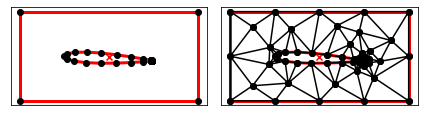

In [29]:
A = dict(vertices=pts, segments=seg, holes=[[0.5, -0.01]])
#B = tr.triangulate(A)
B = tr.triangulate(A, 'qpa0.1')
plt.figure(figsize=(20,4))
tr.compare(plt, A, B)
plt.show()


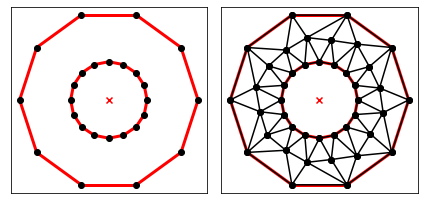

In [205]:
def circle(N, R):
    i = np.arange(N)
    theta = i * 2 * np.pi / N
    pts = np.stack([np.cos(theta), np.sin(theta)], axis=1) * R
    seg = np.stack([i, i + 1], axis=1) % N
    return pts, seg


pts0, seg0 = circle(10, 1.4)
pts1, seg1 = circle(16, 0.6)
pts = np.vstack([pts0, pts1])
seg = np.vstack([seg0, seg1 + seg0.shape[0]])

A = dict(vertices=pts, segments=seg, holes=[[0, 0]])
B = tr.triangulate(A, 'qpa')
#B = tr.triangulate(A, 'qpa0.05')
tr.compare(plt, A, B)
plt.show()

In [245]:
print(seg0)
print(seg1)

[[0 1]
 [1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 6]
 [6 7]
 [7 8]
 [8 9]
 [9 0]]
[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]
 [10 11]
 [11 12]
 [12 13]
 [13 14]
 [14 15]
 [15  0]]
